# Pretrained models pneumonia detection

---


### General Imports

In [4]:
import numpy as np
import pandas as pd
import cv2

import PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import seaborn as sns

### Load Dataset

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
#modify accordingly

train_dir = 'archive/chest_xray/train'
test_dir = 'archive/chest_xray/test'
val_dir = 'archive/chest_xray/val'

In [7]:
train = get_training_data('archive/chest_xray/train')
test = get_training_data('archive/chest_xray/test')
val = get_training_data('archive/chest_xray/val')

C:\Users\Keshav Ganesh\AppData\Local\Temp\ipykernel_21140\1344827095.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
train.shape, test.shape, val.shape

((5216, 2), (624, 2), (16, 2))

### Data Visualisation

Text(0.5, 1.0, 'NORMAL')

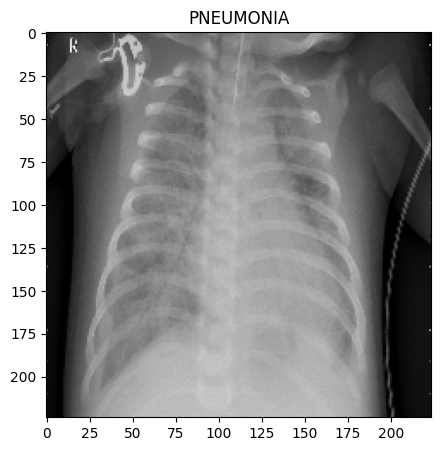

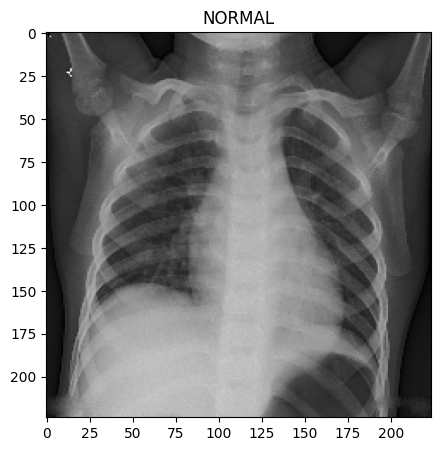

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

<Axes: xlabel='0', ylabel='count'>

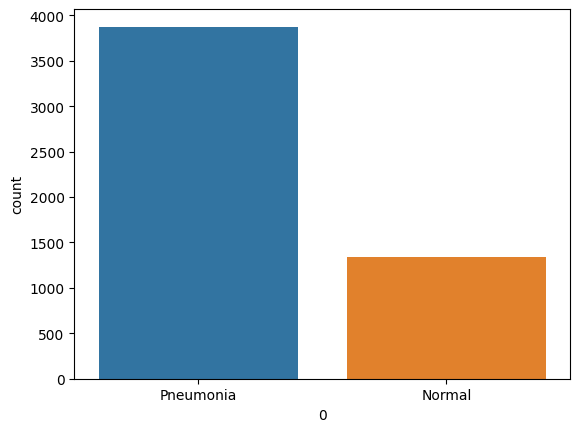

In [10]:
# Visualise class distribution

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

l = pd.DataFrame(l)
sns.countplot(x = 0, data = l)


This is clearly an issue because we have significantly more Pneumonia scans than Normal scans. The issue with class imbalance is that it can lead to biased model performance, as the model may become more inclined to predict the majority class, ignoring the minority class. This results in poor predictive accuracy and an underrepresentation of the minority class. 

### Split into features and labels

In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [12]:
# create class weight dictionary

# Calculate class weights
total_samples = len(y_train)
class_samples_A = y_train.count(0)
class_samples_B = y_train.count(1)
class_weight_A = total_samples / (2 * class_samples_A)
class_weight_B = total_samples / (2 * class_samples_B)

class_weights_dict = {0: class_weight_A, 1: class_weight_B}

print(class_weights_dict)

{0: 0.6730322580645162, 1: 1.9448173005219984}


### Normalization 

In [13]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train.shape, x_val.shape, x_test.shape

((5216, 224, 224), (16, 224, 224), (624, 224, 224))

### Resize data for learning

In [14]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_train.shape, x_val.shape, x_test.shape

((5216, 224, 224, 1), (16, 224, 224, 1), (624, 224, 224, 1))

In [15]:
x_train = np.repeat(x_train,3,-1)
x_test = np.repeat(x_test,3,-1)
x_val = np.repeat(x_val,3,-1)

### Data Augmentation

In [16]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False
    )

# rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True

datagen.fit(x_train)

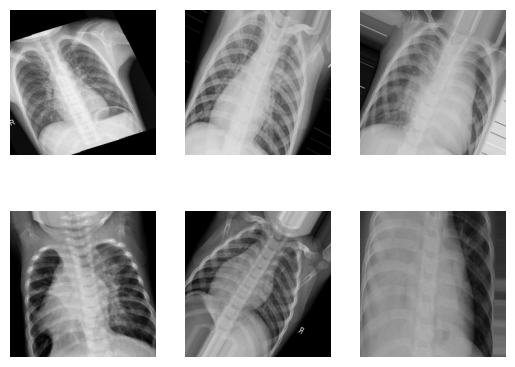

In [17]:
for X_batch, y_batch in datagen.flow(x_train,y_train, batch_size=6):
    for i in range(0, 6):
        plt.subplot(2,3,i+1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    break

## Pretrained Models

In [18]:
IMAGE_SHAPE = (img_size, img_size)

In [19]:
def plot_confusion_matrix(confusion_matrix, classes=["Pneumonia", "Normal"]):
    plt.figure(figsize=(8, 6))
    im = plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Add color bar
    color_bar = plt.colorbar(im)
    color_bar.set_label('Score')

    # Set tick labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Rotate tick labels if needed
    plt.xticks(rotation=45, ha="right")

    # Add text annotations
    thresh = confusion_matrix.max() / 2
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

### Efficient Net

In [18]:
# use pretrained model efficient net link 

pretrained_model = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"

model = tf.keras.Sequential([
    hub.KerasLayer(pretrained_model, trainable=False, input_shape=(img_size, img_size, 3)),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              5330564   
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 5,843,589
Trainable params: 513,025
Non-trainable params: 5,330,564
_________________________________________________________________


In [19]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=16), epochs = 12, 
                    validation_data=datagen.flow(x_val,y_val), 
                    class_weight=class_weights_dict, callbacks=[learning_rate_reduction])

Epoch 1/12
326/326 [==============================] - 233s 675ms/step - loss: 0.3915 - accuracy: 0.8338 - val_loss: 0.2678 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/12
326/326 [==============================] - 202s 618ms/step - loss: 0.2763 - accuracy: 0.8731 - val_loss: 0.7486 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/12
326/326 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.8823
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 206s 632ms/step - loss: 0.2591 - accuracy: 0.8823 - val_loss: 0.6651 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/12
326/326 [==============================] - 201s 617ms/step - loss: 0.2483 - accuracy: 0.8861 - val_loss: 0.4008 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 5/12
326/326 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.8898
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
326/326 [==================

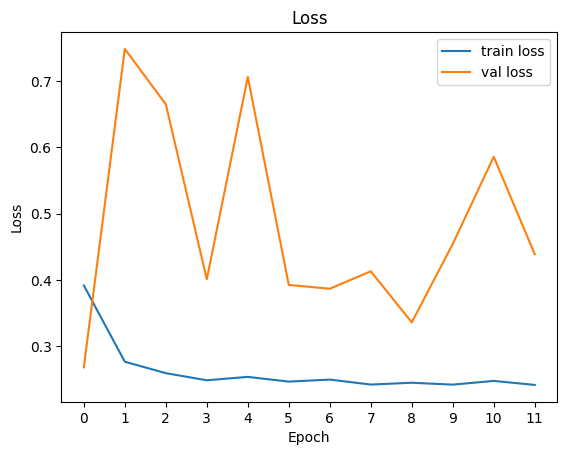

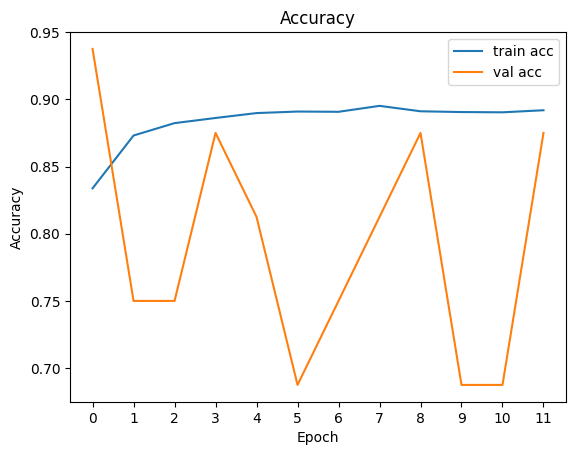

In [21]:
#plot training loss and validation loss

plt.plot(history.history['loss'], label='train loss') 
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(len(history.history['loss'])))
plt.legend()
plt.show()

#plot training accuracy and validation accuracy

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(history.history['accuracy'])))
plt.legend()
plt.show()

20/20 [==============================] - 24s 1s/step - loss: 0.4401 - accuracy: 0.8141
Accuracy:  81.41025900840759 %
Loss:  0.44007864594459534


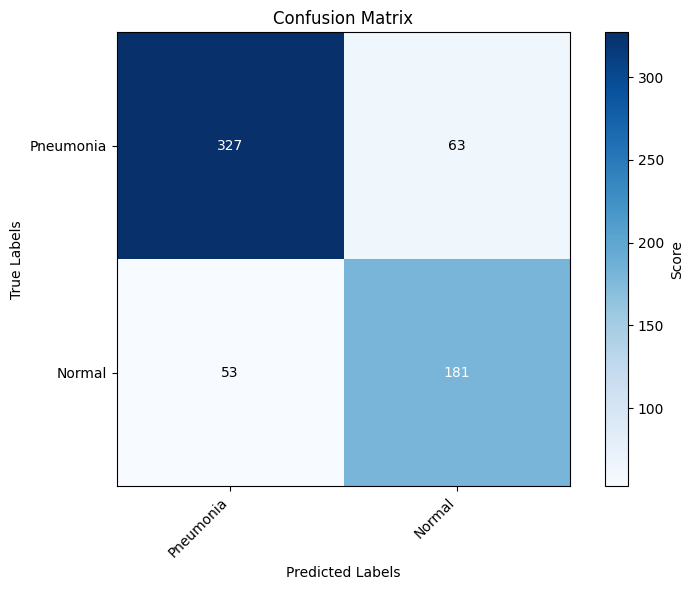

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.84      0.85       390
   Normal (Class 1)       0.74      0.77      0.76       234

           accuracy                           0.81       624
          macro avg       0.80      0.81      0.80       624
       weighted avg       0.82      0.81      0.81       624



In [22]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: ", acc*100, "%")
print("Loss: ", loss)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

### DenseNet

In [19]:
from keras.applications import densenet
from keras.models import Model
from keras.layers import Dense

densenet = densenet.DenseNet121(weights=None, include_top=False, 
                       input_shape=(224, 224, 3), pooling="avg")

x = densenet.output
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=densenet.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:-10]:
    layer.trainable = False

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                             

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=16), epochs = 12 , validation_data=datagen.flow(x_val,y_val), class_weight=class_weights_dict, callbacks=learning_rate_reduction)

Epoch 1/12
326/326 [==============================] - 436s 1s/step - loss: 0.3685 - accuracy: 0.8466 - val_loss: 1.6406 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
326/326 [==============================] - 466s 1s/step - loss: 0.2793 - accuracy: 0.8809 - val_loss: 0.5260 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/12
326/326 [==============================] - 461s 1s/step - loss: 0.2626 - accuracy: 0.8877 - val_loss: 1.0958 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/12
326/326 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.8880
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 454s 1s/step - loss: 0.2601 - accuracy: 0.8880 - val_loss: 0.9852 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/12
326/326 [==============================] - 451s 1s/step - loss: 0.2235 - accuracy: 0.9039 - val_loss: 1.4901 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
326/326 [==============================] - E

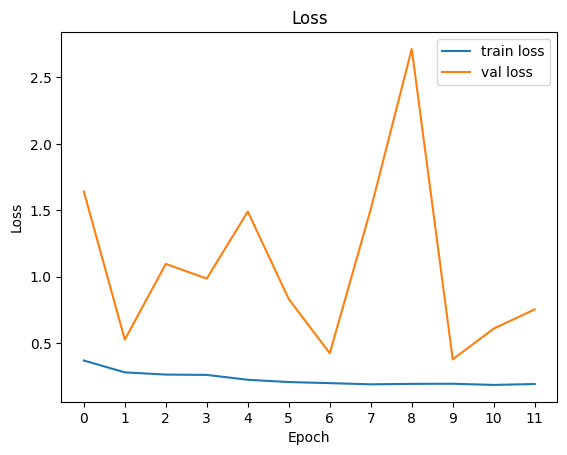

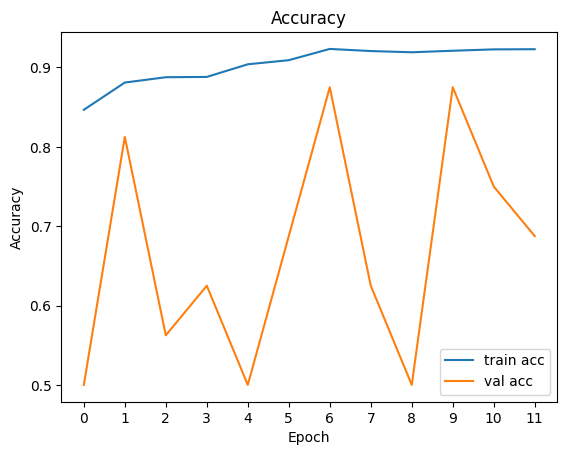

In [22]:
#plot training loss and validation loss

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(len(history.history['loss'])))
plt.legend()
plt.show()

#plot training accuracy and validation accuracy

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(history.history['accuracy'])))
plt.legend()
plt.show()

20/20 [==============================] - 47s 2s/step - loss: 0.2664 - accuracy: 0.8782
Accuracy:  87.82051205635071 %
Loss:  0.266427218914032


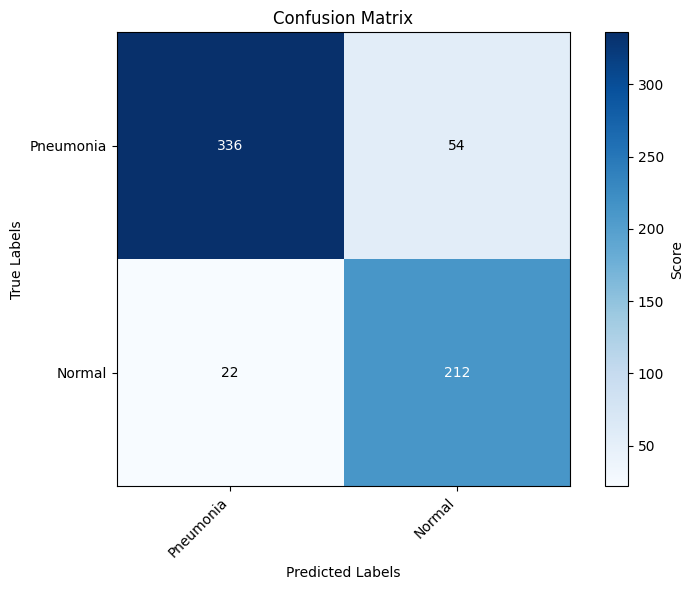

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.86      0.90       390
   Normal (Class 1)       0.80      0.91      0.85       234

           accuracy                           0.88       624
          macro avg       0.87      0.88      0.87       624
       weighted avg       0.89      0.88      0.88       624



In [23]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: ", acc*100, "%")
print("Loss: ", loss)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

### CheXNet (uses Densenet121)

In [18]:
from keras.applications import densenet
from keras.models import Model
from keras.layers import Dense

# https://www.kaggle.com/datasets/theewok/chexnet-keras-weights

densenet = densenet.DenseNet121(weights=None, include_top=False, 
                       input_shape=(224, 224, 3), pooling="avg")
output = tf.keras.layers.Dense(14, activation='sigmoid', name='output')(densenet.layers[-1].output)
model = tf.keras.Model(inputs=[densenet.input], outputs=[output])
model.load_weights("./CheXNet_weights.h5")

x = model.output
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=model.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:-10]:
    layer.trainable = False

model.summary()

CheXNet loaded
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                             

In [19]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=16), epochs = 12 , validation_data=datagen.flow(x_val,y_val), class_weight=class_weights_dict, callbacks=learning_rate_reduction)

Epoch 1/12
326/326 [==============================] - 432s 1s/step - loss: 0.5756 - accuracy: 0.8169 - val_loss: 0.5744 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/12
326/326 [==============================] - 412s 1s/step - loss: 0.4427 - accuracy: 0.8775 - val_loss: 0.5471 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/12
326/326 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8765
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 376s 1s/step - loss: 0.3908 - accuracy: 0.8765 - val_loss: 0.7420 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/12
326/326 [==============================] - 375s 1s/step - loss: 0.3416 - accuracy: 0.8936 - val_loss: 0.8563 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 5/12
326/326 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.9059
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
326/326 [==============================

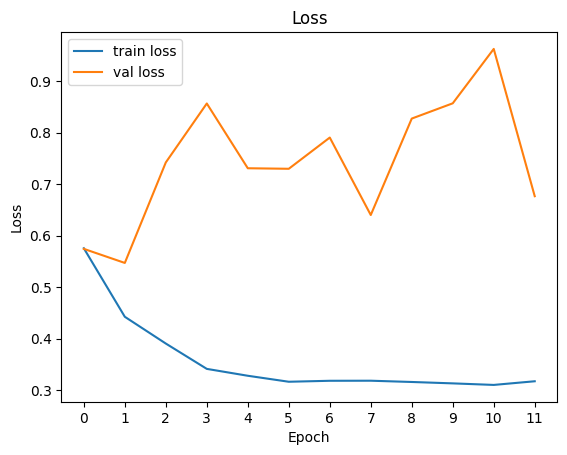

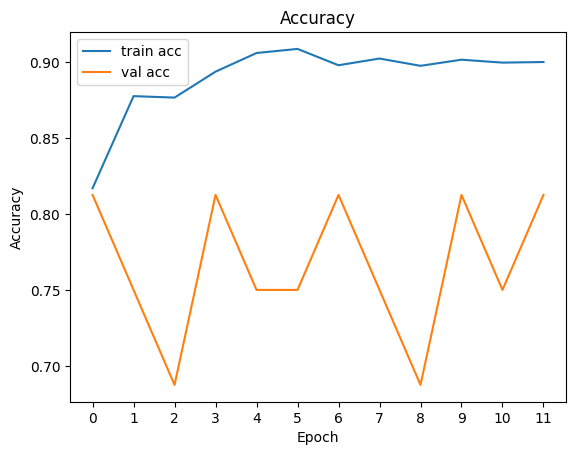

In [21]:
#plot training loss and validation loss

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(len(history.history['loss'])))
plt.legend()
plt.show()

#plot training accuracy and validation accuracy

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(history.history['accuracy'])))
plt.legend()
plt.show()

20/20 [==============================] - 47s 2s/step - loss: 0.3142 - accuracy: 0.8910
Accuracy:  89.10256624221802 %
Loss:  0.3141637146472931


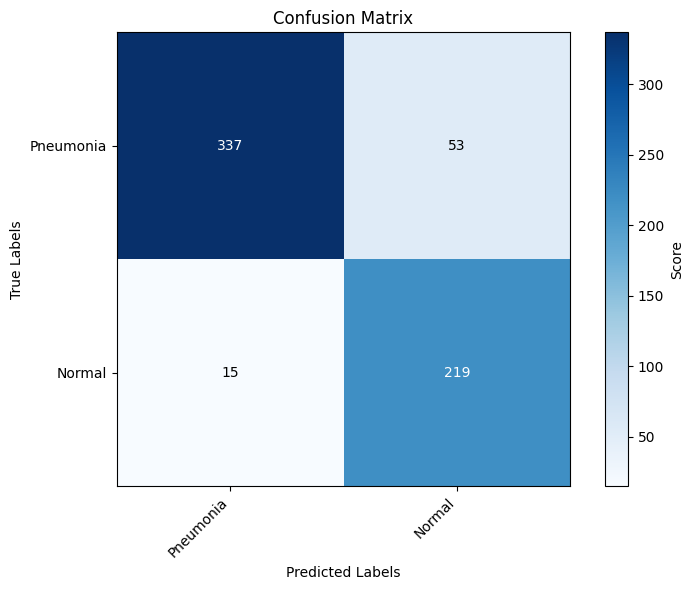

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.86      0.91       390
   Normal (Class 1)       0.81      0.94      0.87       234

           accuracy                           0.89       624
          macro avg       0.88      0.90      0.89       624
       weighted avg       0.90      0.89      0.89       624



In [22]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: ", acc*100, "%")
print("Loss: ", loss)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

### MobileNet

In [22]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=predictions)

for layer in model.layers[:-5]:
    layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [23]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=16), epochs = 12 , validation_data=datagen.flow(x_val,y_val), class_weight=class_weights_dict, callbacks=learning_rate_reduction)

Epoch 1/12
326/326 [==============================] - 121s 363ms/step - loss: 0.2927 - accuracy: 0.8867 - val_loss: 0.5007 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/12
326/326 [==============================] - 114s 348ms/step - loss: 0.1797 - accuracy: 0.9298 - val_loss: 0.9872 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/12
326/326 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9339
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 112s 343ms/step - loss: 0.1645 - accuracy: 0.9339 - val_loss: 0.3871 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/12
326/326 [==============================] - 111s 341ms/step - loss: 0.1295 - accuracy: 0.9511 - val_loss: 0.3134 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/12
326/326 [==============================] - 114s 348ms/step - loss: 0.1248 - accuracy: 0.9461 - val_loss: 0.1715 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 6/12
326/326 [================

In [25]:
model.save('mobilenet.h5', save_format='h5')

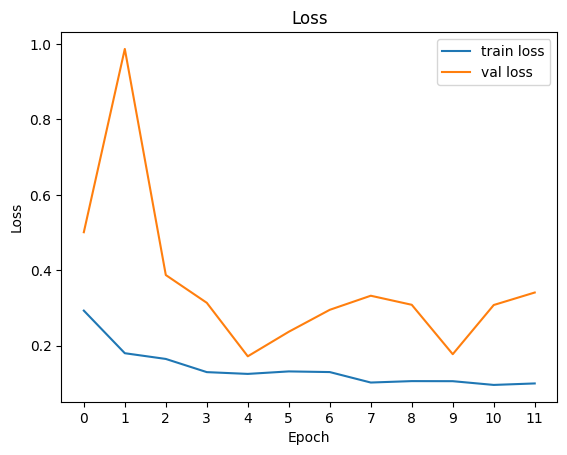

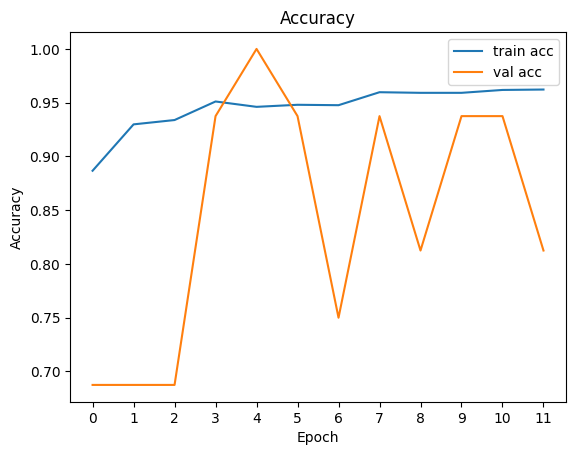

In [26]:
#plot training loss and validation loss

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(len(history.history['loss'])))
plt.legend()
plt.show()

#plot training accuracy and validation accuracy

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(history.history['accuracy'])))
plt.legend()
plt.show()

20/20 [==============================] - 11s 519ms/step - loss: 0.2157 - accuracy: 0.9279
Accuracy:  92.78846383094788 %
Loss:  0.21567402780056


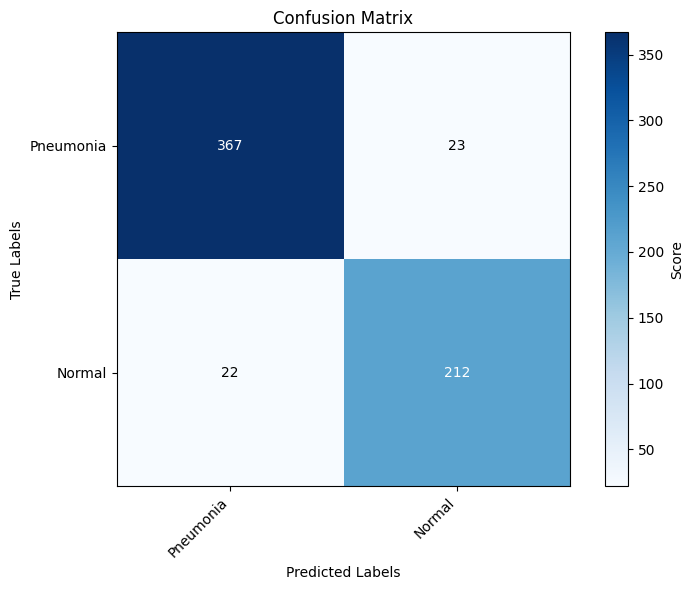

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.94      0.94       390
   Normal (Class 1)       0.90      0.91      0.90       234

           accuracy                           0.93       624
          macro avg       0.92      0.92      0.92       624
       weighted avg       0.93      0.93      0.93       624



In [27]:
from sklearn.metrics import confusion_matrix, classification_report

model = tf.keras.models.load_model('mobilenet.h5')

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: ", acc*100, "%")
print("Loss: ", loss)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

### Resnet

In [19]:
from keras.applications import ResNet152V2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:-5]:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=16), epochs = 12 , validation_data=datagen.flow(x_val,y_val), class_weight=class_weights_dict, callbacks=learning_rate_reduction)

Epoch 1/12
326/326 [==============================] - 693s 2s/step - loss: 0.2914 - accuracy: 0.8894 - val_loss: 0.5421 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/12
326/326 [==============================] - 676s 2s/step - loss: 0.1791 - accuracy: 0.9300 - val_loss: 0.5277 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/12
326/326 [==============================] - 666s 2s/step - loss: 0.1645 - accuracy: 0.9339 - val_loss: 0.3761 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/12
326/326 [==============================] - 677s 2s/step - loss: 0.1663 - accuracy: 0.9381 - val_loss: 0.3811 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/12
326/326 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9415
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 694s 2s/step - loss: 0.1561 - accuracy: 0.9415 - val_loss: 1.3575 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/12
326/326 [==============================] - 687s 

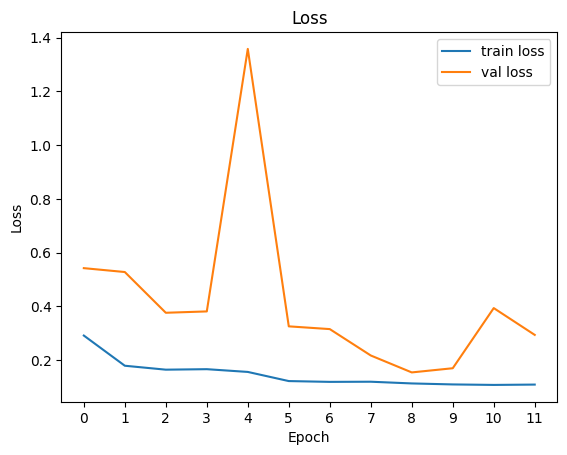

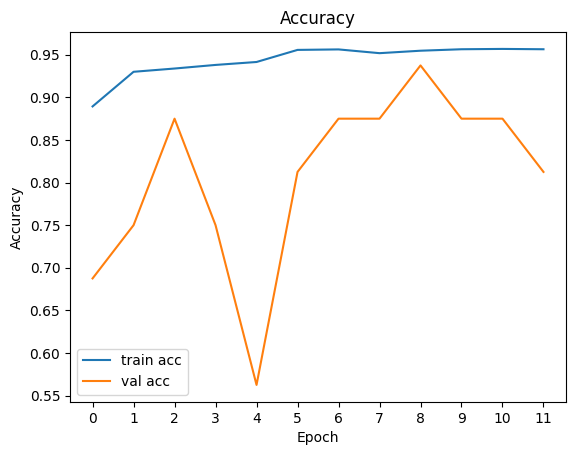

In [22]:
#plot training loss and validation loss

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(len(history.history['loss'])))
plt.legend()
plt.show()

#plot training accuracy and validation accuracy

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(history.history['accuracy'])))
plt.legend()
plt.show()

20/20 [==============================] - 74s 4s/step - loss: 0.2436 - accuracy: 0.9054
Accuracy:  90.54487347602844 %
Loss:  0.24360451102256775


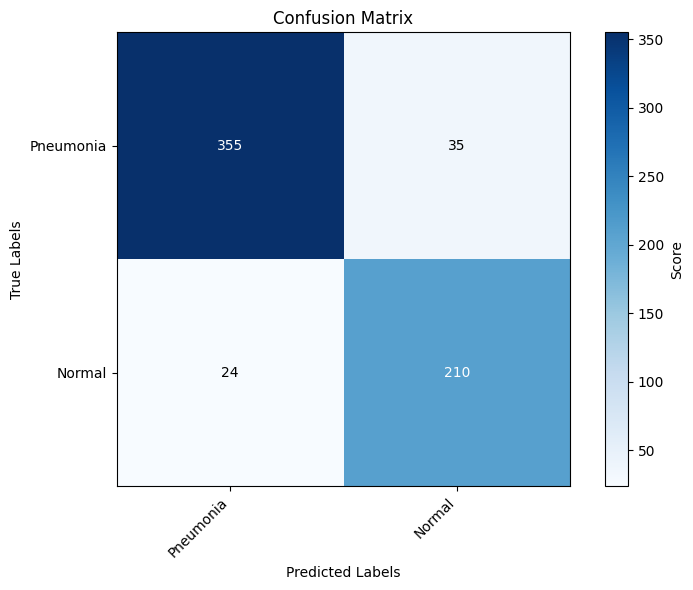

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.91      0.92       390
   Normal (Class 1)       0.86      0.90      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [23]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: ", acc*100, "%")
print("Loss: ", loss)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

### Results

| Model |  Accuracy |
| --- | --- |
| EfficientNetB0 | 0.8141 |
| DenseNet121 | 0.8782 |
| CheXNet | 0.8910 |
| MobileNet | 0.9278 |
| ResNet152v2 | 0.9054 |


| Model | Trainable Params | Non-trainable Params | Total Params |
| --- | --- | --- | --- |
| EfficientNetB0 | 513,025 | 5,330,564 | 5,843,589 |
| DenseNet121 | 167,169 | 6,871,360 | 7,038,529 |
| CheXNet | 180,509 | 6,871,360 | 7,051,869 |
| MobileNet | 1,052,673 | 3,226,816 | 4,279,489 |
| ResNet152v2 | 2,103,297 | 58,327,552 | 60,430,849 |
| Custom CNN | 979,329 | 960 | 980,289 |